In [1]:
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from numpy.random import rand
import collections
import datetime
import dateutil.parser
import pandas as pd

In [2]:
# params
# actions = 6
# actionReward = [3, 13, -1, -20, 2, 0]
# regularActionDistribution = [0.561, 0.257, 0.156, 0.015, 0.02]
# crisisActionDistribution = [0.479, 0.106, 0.321, 0.086, 0]
# actionsToCurateLBCR = 70
# interactionFrequencyPerBlock = 0.07875
# interactionFrequencyPerBlock = 1.2675

aaveTxs = pd.read_csv("aave.csv")
aaveTxs.sort_values(by=['dateyear', 'datemonth', 'dateday', 'datehour', 'dateminute'])

synthetixTxs = pd.read_csv("synthetix.csv")
synthetixTxs.sort_values(by=['dateyear', 'datemonth', 'dateday', 'datehour', 'dateminute'])

compoundTxs = pd.read_csv("compound.csv")
compoundTxs.sort_values(by=['dateyear', 'datemonth', 'dateday', 'datehour', 'dateminute'])

makerTxs = pd.read_csv("maker.csv")
makerTxs.sort_values(by=['dateyear', 'datemonth', 'dateday', 'datehour', 'dateminute'])

ethDaiPriceCSV = pd.read_csv("ethdaiprice.csv")

In [12]:
class LbcrSimulator:
    
    def __init__(
        self,
        txs, 
        userCount, 
        rewards,
        ethDaiPriceFeed,
        layerCount, 
        layerScores, 
        layerDiscounts,
        layerCurationInterval,
        startIndex = 0, 
        movingAverageWindow = 15,
        csvMinutesInInterval = 30,
        priceFeedScaleFactor = 1000
    ):
        self.txs = txs
        self.userCount = userCount
        self.rewards = rewards
        self.ethDaiPriceFeed = ethDaiPriceFeed
        self.layerCount = layerCount
        self.layerScores = layerScores
        self.layerDiscounts = layerDiscounts
        self.layerCurationInterval = layerCurationInterval
        self.startIndex = startIndex
        self.movingAverageWindow = movingAverageWindow
        self.csvMinutesInInterval = csvMinutesInInterval
        self.priceFeedScaleFactor = priceFeedScaleFactor
        
        self.userScore = [0] * userCount
        self.userLayers = [0] * userCount

        self.userLayerPositionsOverTime = [[] for _ in range(userCount)]
        self.userLayerDiscountsOverTime = [[] for _ in range(userCount)]
        self.userScoreOverTime = [[] for _ in range(userCount)]
        
        self.curationDates = []
        self.pricesAtCuration = []
        self.roundActionCounts = []
        self.avgScores = []
        self.avgLayers = []
        self.avgDiscountPerInterval = []
        self.currentRoundActionCount = 0
        self.ethereumBlocksPerMinute = 4
        self.blocksPerCsvInterval = self.csvMinutesInInterval * self.ethereumBlocksPerMinute
    
    def movingAverage(self, v):
        windowSize = self.movingAverageWindow
        length = min(len(v), windowSize)
        if not length:
            return 0
        return sum(v[:-length]) / length

    def curate(self, currentTx):
        for user in range(self.userCount):
            newLayer = 0
            self.userScoreOverTime[user].append(self.userScore[user])

            while newLayer + 1 < self.layerCount and self.userScore[user] >= self.layerScores[newLayer + 1]:
                newLayer += 1
            self.userLayers[user] = newLayer
            self.userScore[user] = 0
            self.userLayerPositionsOverTime[user].append(newLayer)
            newLayerDiscount = self.layerDiscounts[newLayer]
            self.userLayerDiscountsOverTime[user].append(newLayerDiscount) 
        dateFormat = [
            currentTx.dateyear,
            currentTx.datemonth,
            currentTx.dateday,
            currentTx.datehour,
            str(int(currentTx.dateminute) * self.csvMinutesInInterval),
            "00"
        ]
        curationDate = datetime.datetime(*map(int, dateFormat))
        self.curationDates.append(curationDate)
        self.roundActionCounts.append(self.currentRoundActionCount)
        self.currentRoundActionCount = 0

    def drawActionFromDistribution(self, actionCounts, totalCount):
        randomDraw = rand()
        sum = 0
        for (key, actionCount) in actionCounts.items():
            sum += actionCount / totalCount
            if randomDraw < sum:
                return key
        return None

    def avg(self, v):
        if not v:
            return None
        return sum(v)/len(v)

    def countActionsAtOnChainTime(self, index):
        counts = collections.defaultdict(int)
        totalCount = 0
        tx = self.txs.iloc[index]
        counts[tx.f0_] = tx.f1_
        totalCount += tx.f1_
        while index + 1 < len(self.txs) and tx.dateyear == self.txs.iloc[index + 1].dateyear and \
            tx.datemonth == self.txs.iloc[index + 1].datemonth and \
            tx.dateday == self.txs.iloc[index + 1].dateday and \
            tx.datehour == self.txs.iloc[index + 1].datehour and \
            tx.dateminute == self.txs.iloc[index + 1].dateminute:

            tx = self.txs.iloc[index]
            counts[tx.f0_] += tx.f1_
            totalCount += tx.f1_
            index += 1
        
        return (counts, totalCount)
    
    def hasUserActedInCurrentBlock(self, totalOnChainActionCount):
        return rand() <= totalOnChainActionCount / (self.blocksPerCsvInterval * self.userCount)
    
    def idealCurationNumberUpToIndex(self, index):
        return (index * self.blocksPerCsvInterval) / self.layerCurationInterval
    
    def currentRoundScaleFactorBasedOnVolumes(self):
        return self.movingAverage(self.roundActionCounts) / self.currentRoundActionCount
    
    def simulate(self):
        priceFeedIndex = 0
        i = self.startIndex - 1
        while i + 1 < len(self.txs):
        # while i + 1 < len(self.txs) and i < 4100:
            i += 1
            onChainActionCountDict, totalOnChainActionCount = self.countActionsAtOnChainTime(i)

            for j in range(self.blocksPerCsvInterval):
                for user in range(self.userCount):
                    if self.hasUserActedInCurrentBlock(totalOnChainActionCount):
                        action = self.drawActionFromDistribution(onChainActionCountDict, totalOnChainActionCount)
                        self.currentRoundActionCount += 1
                        if action in self.rewards:
                            self.userScore[user] += self.rewards[action]
                        if self.idealCurationNumberUpToIndex(i) >= len(self.curationDates) * self.currentRoundScaleFactorBasedOnVolumes():
                            self.curate(self.txs.iloc[i])
                            while priceFeedIndex < len(self.ethDaiPriceFeed) \
                                and dateutil.parser.parse(self.ethDaiPriceFeed.iloc[priceFeedIndex].time, ignoretz=True) < self.curationDates[-1]:
                                priceFeedIndex += 1
                            self.pricesAtCuration.append(self.ethDaiPriceFeed.iloc[priceFeedIndex].close / self.priceFeedScaleFactor)

    def computeSimulationStatistics(self):
        for i in range(len(self.userLayerPositionsOverTime)):
            self.avgLayers.append(self.avg(self.userLayerPositionsOverTime[i]))
            self.avgScores.append(self.avg(self.userScoreOverTime[i]))

        for i in range(len(self.userLayerDiscountsOverTime[0])):
            discounts = []
            for user in range(self.userCount):
                discounts.append(self.userLayerDiscountsOverTime[user][i])
            self.avgDiscountPerInterval.append(self.avg(discounts))
            
        print(self.avg(self.avgScores))
        print(self.avg(self.avgLayers))
#         print(self.avg(self.avgDiscountPerInterval[25:]))
#         print(len(self.avgDiscountPerInterval))

    def displaySimulationResults(self):
        plt.hist(self.avgLayers, bins=list(range(self.layerCount)))

        plt.figure()
        plt.plot(self.curationDates, self.avgDiscountPerInterval, '.-')
        plt.plot(self.curationDates, self.pricesAtCuration, '.-')
        plt.gcf().autofmt_xdate()
        plt.show()
    
# crisis:
# 0.01611379310344828

# regular:
# 0.07072195121951218

31.060579710144943
1.7394202898550728


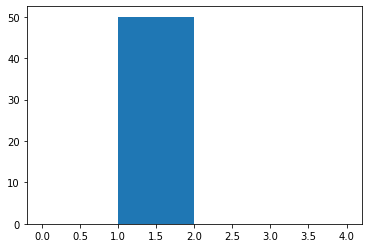

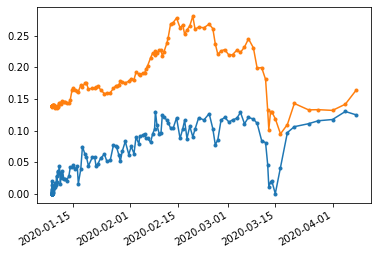

In [16]:
aaveUserCount = 50

# deposit, borrow, repay, liquidate, repay, flashLoan, others
# 0xd2d0e066, 0xc858f5f9, 0x5ceae9c4, 0x00a718a9, 0x5cffe9de, ...
aaveRewards = {
    "0xd2d0e066": 3,
    "0xc858f5f9": 25,
    "0x5ceae9c4": -15,
    "0x00a718a9": -20,
    "0x5cffe9de": 3
}

layerCount = 5
layerScores = [0, 10, 20, 29, 37]
layerDiscounts = [0, 0.033, 0.066, 0.1, 0.133]

layerCurationInterval = 3900

aaveSimulator = LbcrSimulator(aaveTxs, aaveUserCount, aaveRewards, ethDaiPriceCSV, layerCount, layerScores, layerDiscounts, layerCurationInterval)
aaveSimulator.simulate()
aaveSimulator.computeSimulationStatistics()
aaveSimulator.displaySimulationResults()



18.425777777777775
1.3153703703703696


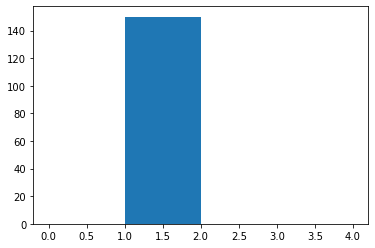

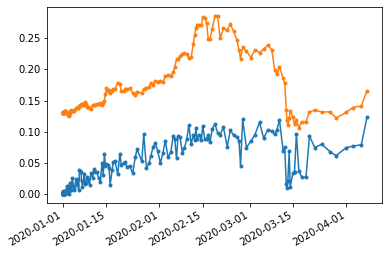

In [18]:
compoundUserCount = 150
# mint (deposit): 0xa0712d68 (cToken), 0x1249c58b (cETH)
# borrow (cETH, cToken): 0xc5ebeaec
# repay: 0x2608f818 (repayBorrowBehalf - cToken), 0x0e752702 (repayBorrow)
# liquidate: 0xf5e3c462

compoundRewards = {
    # mint
    "0xa0712d68": 2,
    "0x1249c58b": 2,
    
    # borrow
    "0xc5ebeaec": 25,
    
    # repay
    "0x2608f818": -15,
    "0x0e752702": -15,
    
    # liquidate
    "0xf5e3c462": -20
}

layerCount = 5
layerScores = [0, 10, 20, 29, 37]
layerDiscounts = [0, 0.033, 0.066, 0.1, 0.133]

layerCurationInterval = 6000

compoundSimulator = LbcrSimulator(compoundTxs, compoundUserCount, compoundRewards, ethDaiPriceCSV, layerCount, layerScores, layerDiscounts, layerCurationInterval)
compoundSimulator.simulate()
compoundSimulator.computeSimulationStatistics()
compoundSimulator.displaySimulationResults()

28.4875
1.214411764705882


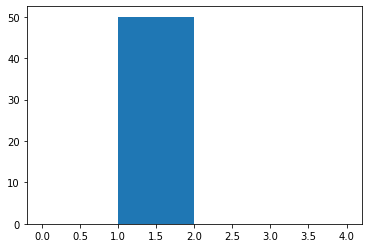

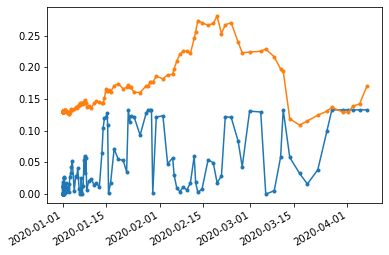

In [20]:
synthetixUserCount = 50
# issue (borrow): 0xaf086c7e (issueMaxSynths), 0x8a290014 (issueSynths)
# burn (repay): 0x295da87d (burnSynths)

synthetixRewards = {
    # issue
    "0xaf086c7e": 20,
    "0x8a290014": 20,
    
    # burn
    "0x295da87d": -15
}

layerCount = 5
layerScores = [0, 10, 20, 29, 37]
layerDiscounts = [0, 0.033, 0.066, 0.1, 0.133]

layerCurationInterval = 7000

synthetixSimulator = LbcrSimulator(synthetixTxs, synthetixUserCount, synthetixRewards, ethDaiPriceCSV, layerCount, layerScores, layerDiscounts, layerCurationInterval)
synthetixSimulator.simulate()
synthetixSimulator.computeSimulationStatistics()
synthetixSimulator.displaySimulationResults()


In [ ]:
makerUserCount = 50
# join (mint/borrow): 0x3b4da69f
# exit (burn/repay): 0xef693bed

makerRewards = {
    # issue
    "0xaf086c7e": 20,
    
    # burn
    "0xef693bed": -15
}

layerCount = 5
layerScores = [0, 10, 20, 29, 37]
layerDiscounts = [0, 0.033, 0.066, 0.1, 0.133]

layerCurationInterval = 3900

makerSimulator = LbcrSimulator(makerTxs, makerUserCount, makerRewards, ethUSDPriceCSV, layerCount, layerScores, layerDiscounts, layerCurationInterval)
makerSimulator.simulate()
makerSimulator.computeSimulationStatistics()
makerSimulator.displaySimulationResults()



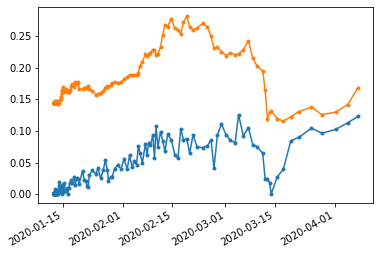

regular reduction 0.07879414634146342
crisis reduction 0.02827714285714286


In [14]:
plt.plot(curationDates, avgReduction, '.-')
plt.plot(curationDates, pricesAtCuration, '.-')
plt.gcf().autofmt_xdate()
plt.show()
# print(avg(avgScores))
# print(avg(avgLayers))
# print(avg(avgReduction))
print("regular reduction", avg(avgReduction[97:-15]))
print("crisis reduction", avg(avgReduction[-14:-7]))